## **Define function for normalization and image display**

In [1]:
#image normalization
def normalization(img, range):
  normed_img = img/(img.max()/range)
  return normed_img

In [2]:
def plotImage(image, title):
  plt.imshow(image, 'gray', vmin = 0, vmax = 255)
  plt.title(title)
  fig = plt.gcf()
  fig.set_size_inches(13,13)
  plt.show()

In [3]:
def convolve2d(image, kernel, stride = 1):
  kernel = np.flipud(np.fliplr(kernel))

  k_sizeX, k_sizeY = kernel.shape

  im_sizeX, im_sizeY = image.shape

  padding = int(np.floor((k_sizeX-1)/2)) # padding = ((k-1) / 2)

  #output image (convolved with image)
  new_image = np.zeros((im_sizeX + 2*padding, im_sizeY + 2*padding))
  new_image[padding: im_sizeX+padding, padding: im_sizeY + padding] = image[:,:]

  output = np.zeros(new_image.shape)

  new_im_sizeX, new_im_sizeY = new_image.shape
  for y in range(new_im_sizeY):
    if y > new_im_sizeY-k_sizeY:
      break

    for x in range(new_im_sizeX):
      if x > new_im_sizeX-k_sizeX:
        break
      
      if( y % stride == 0 and x%stride == 0):
        
        output[int(np.floor((2*x+k_sizeX)/2)),int(np.floor((2*y+k_sizeY)/2))] = (kernel * new_image[x:x+k_sizeX, y:y+k_sizeY]).sum()

  return output

## **Read and Display input image**

In [4]:
# define some global variables
img_name = 'test2.bmp'
output = False

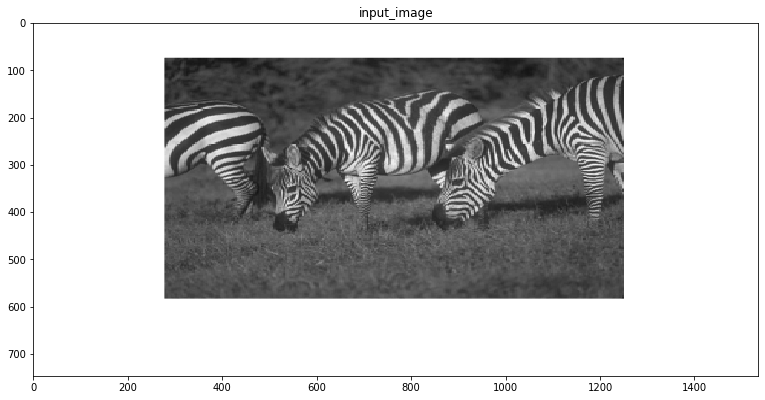

In [5]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread(img_name) 
# cv2.cvtColor(img, CV_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plotImage(img,"input_image")

In [6]:
img.shape

(747, 1536)

## **Gaussian Smoothing**

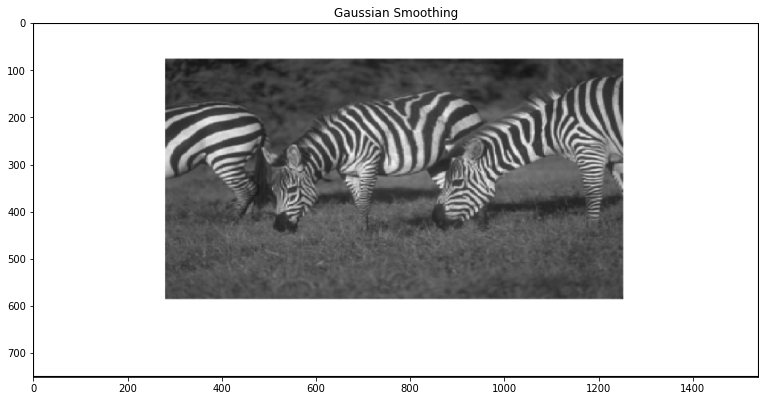

In [7]:
filter = (1/273)*np.array([[1,4,7,4,1],[4,16,26,16,4],[7,26,41,26,7],[4,16,26,16,4],[1,4,7,4,1]])
new_img = convolve2d(img, filter)
new_img = normalization(abs(new_img), 255)
plotImage(new_img, "Gaussian Smoothing")
if output:
  cv2.imwrite("Gaussian Smoothing_"+ img_name, new_img)

## **gradient operation**

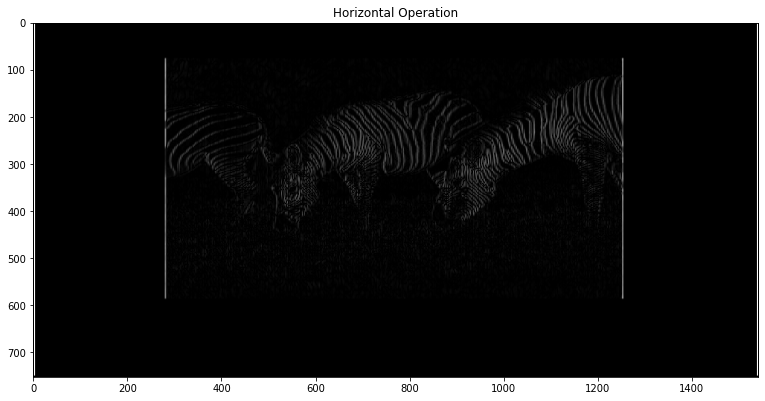

In [8]:
#apply the horizontal sobel filter to the image
horizontal_sobel_filter = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
img_horizontal = convolve2d(new_img, horizontal_sobel_filter) 
normed_img_horizontal = normalization(abs(img_horizontal), 255)
plotImage(normed_img_horizontal, "Horizontal Operation")
if output:
  cv2.imwrite("Horizontal_"+img_name, normed_img_horizontal)

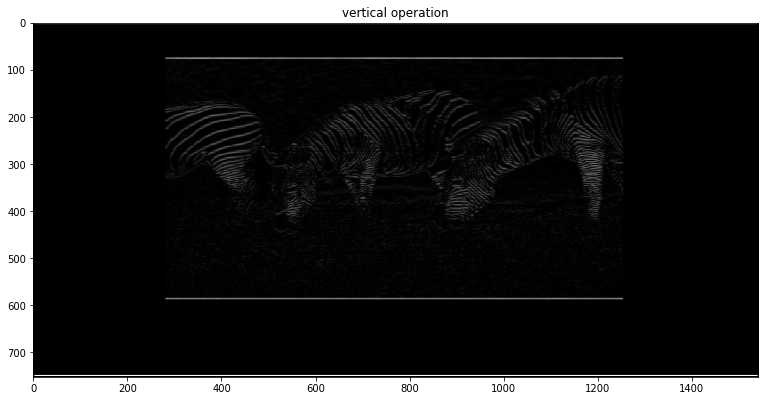

In [9]:
#apply the vertical sobel filter to the image
vertical_sobel_filter = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
img_vertical = convolve2d(new_img,vertical_sobel_filter)
normed_img_vertical = normalization(abs(img_vertical), 255)
plotImage(normed_img_vertical, "vertical operation")
if output:
  cv2.imwrite("Vertical_"+img_name, normed_img_vertical)

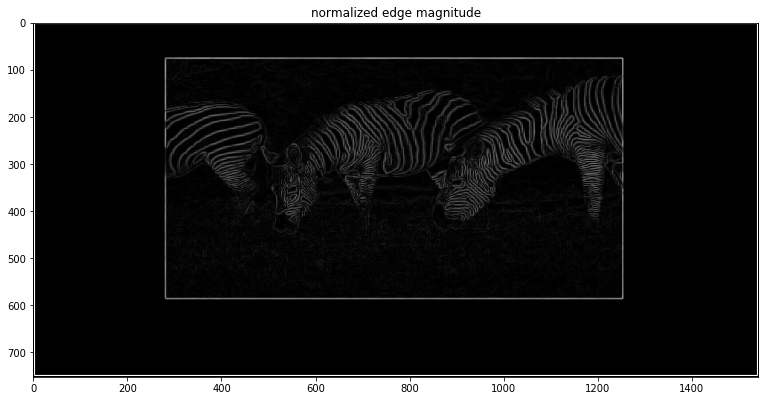

In [10]:
magnitude_change_img = np.sqrt(img_horizontal*img_horizontal + img_vertical*img_vertical)
normed_magnitude_change_img = normalization(abs(magnitude_change_img), 255)
plotImage(normed_magnitude_change_img, "normalized edge magnitude")
gradient_angle = np.arctan2(img_vertical, img_horizontal)
if output:
  cv2.imwrite("Normalized Edge Magnitude_" + img_name, normed_magnitude_change_img)

## **Non-max Suppression**

In [11]:
def non_max_suppression(img, direction):
  img_height = img.shape[0]
  img_width = img.shape[1]

  new_img = np.zeros(img.shape)
  angle = direction * 180 /np.pi
  # print(angle)
  angle[angle<0] += 180
  # print(angle)
  for i in range(img_height):
    for j in range(img_width):
        try:
          # print(angle[i][j][c])
          before_pixel = 255
          after_pixel = 255
          # link the gradient angle to the pixel direction
          if ( 0 <= angle[i][j] and angle[i][j] < 22.5) or (157.5 <= angle[i][j] and angle[i][j] <=180):
            q = img[i][j+1]
            r = img[i][j-1]
          elif (22.5 <= angle[i][j] and angle[i][j] <67.5):
            q = img[i+1][j-1]
            r = img[i-1][j+1]
          elif (67.5 <= angle[i][j] and angle[i][j] <112.5):
            q = img[i+1][j]
            r = img[i-1][j]
          elif (112.5 <= angle[i][j] and angle[i][j] <157.5):
            q = img[i-1][j-1]
            r = img[i+1][j+1]
        
          if (img[i][j] >= q) and (img [i][j] >= r):
            new_img[i][j] = img[i][j]
          else:
            new_img[i][j] = 0
        except IndexError:
            pass
  return new_img

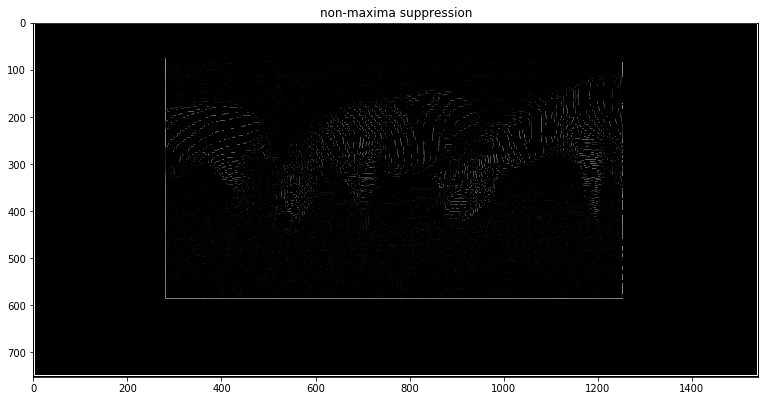

In [12]:
nms_img = non_max_suppression(normed_magnitude_change_img, gradient_angle)
normed_nms_img = normalization(nms_img, 255) #apply normalization
plotImage(normed_nms_img, "non-maxima suppression")
if output:
  cv2.imwrite("non-maxima suppression_" + img_name, normed_nms_img )

## **P-Tile Threshold**

In [13]:
def p_tile(img, tile):
  histogram = plt.hist(img.flatten(), bins=256)
  # print(histogram)
  threshold = find_threshold(tile, histogram)
  new_img, edge_num = binary(img, threshold)

  return new_img, threshold, edge_num


def find_threshold(tile, histogram):
  sum1 = 0
  pixel_sum = 0
  index = 1
  # print(histogram)

  for i in histogram[0][1:]: # plot the histogram and exclude the the pixel value == 0
    pixel_sum += i

  bg_threshold = pixel_sum * (100-tile) / 100 # set the threshold

  for i in histogram[0][1:]:
    sum1 += i
    if sum1 > bg_threshold:
      # print("index", index)
      return histogram[1][index]
    index += 1
  
def binary(img, threshold):
  foreground = 255
  background = 0
  edge_num = 0
  img_height = img.shape[0]
  img_width = img.shape[1]
  new_img = np.zeros((img_height, img_width))
  for i in range(img_height):
    for j in range(img_width):
      if img[i][j] >= threshold:
        new_img[i,j] = foreground #set the pixel greater than threshold as edge
        edge_num += 1
        # print("yes")
      else:
        new_img[i,j] = background
  return new_img, edge_num

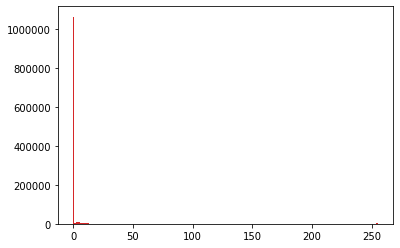

In [14]:
new_img_10, thres_10, edge_num_10 = p_tile(normed_nms_img, 10)
new_img_20, thres_20, edge_num_20 = p_tile(normed_nms_img, 20)
new_img_30, thres_30, edge_num_30 = p_tile(normed_nms_img, 30)
new_img_50, thres_50, edge_num_50 = p_tile(normed_nms_img, 50)

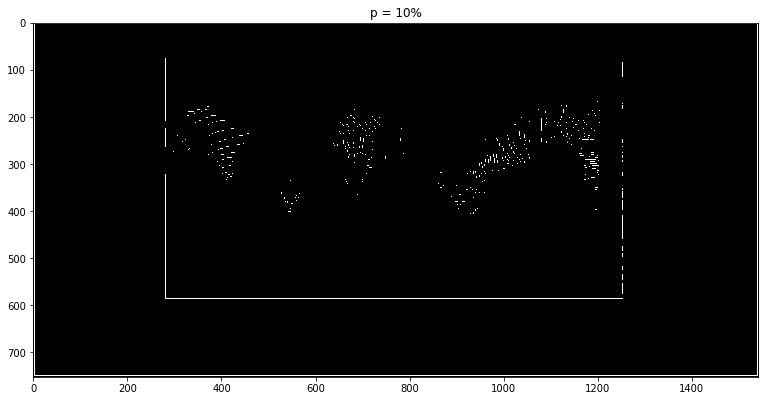

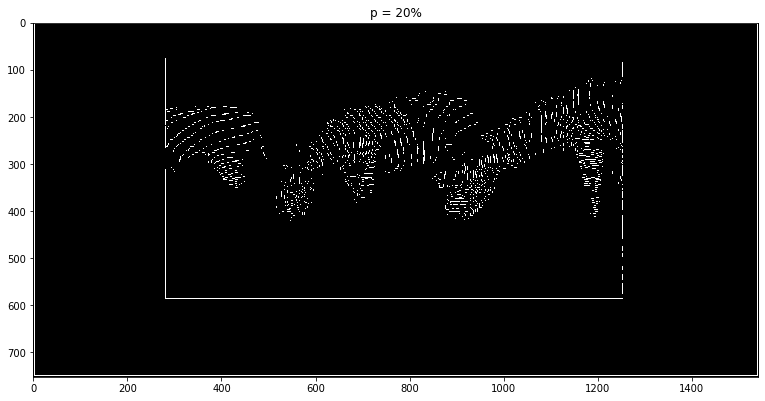

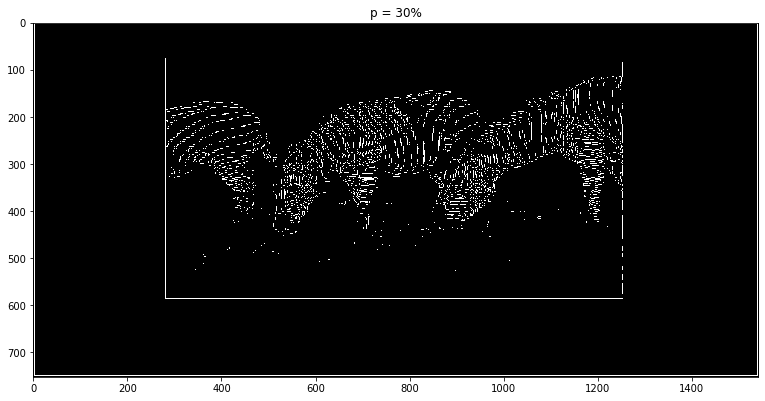

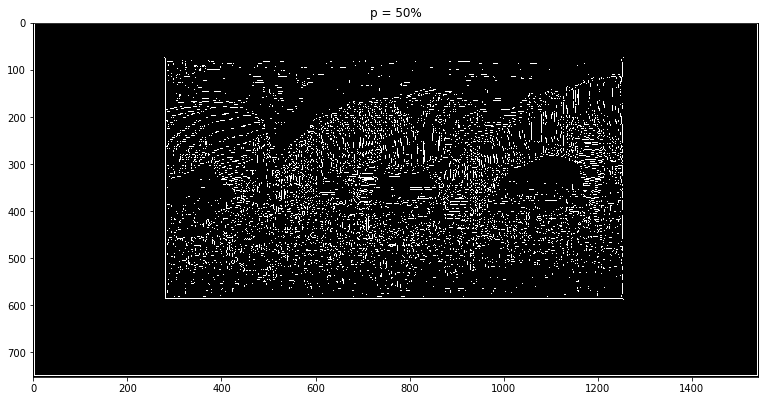

In [15]:
#plot the image for each threshold
plotImage(new_img_10, "p = 10%")
plotImage(new_img_20, "p = 20%")
plotImage(new_img_30, "p = 30%")
plotImage(new_img_50, "p = 50%")

if output:
  cv2.imwrite("p: 10%_" + img_name, new_img_10 )
  cv2.imwrite("p: 20%_" + img_name, new_img_20 )
  cv2.imwrite("p: 30%_" + img_name, new_img_30 )
  cv2.imwrite("p: 40%_" + img_name, new_img_50 )

In [17]:
print("Threshold for p = 10%", thres_10)
print("Threshold for p = 20%", thres_20)
print("Threshold for p = 30%", thres_30)
print("Threshold for p = 50%", thres_50)

print("total number of edges detected for p = 10%", edge_num_10)
print("total number of edges detected for p = 20%", edge_num_20)
print("total number of edges detected for p = 30%", edge_num_30)
print("total number of edges detected for p = 50%", edge_num_50)

Threshold for p = 10% 75.703125
Threshold for p = 20% 44.82421875
Threshold for p = 30% 17.9296875
Threshold for p = 50% 6.97265625
total number of edges detected for p = 10% 9947
total number of edges detected for p = 20% 19842
total number of edges detected for p = 30% 29456
total number of edges detected for p = 50% 53934
